### Variational Auto encoder (VAE)
**Author**: @leopauly | cnlp@leeds.ac.uk <br>
**Description**: An implementation of variational autoencoder. A combination of MNIST and USPS charactor recognition datasets is used for training and testing the model.


In [1]:
## Setting seed
from numpy.random import seed
seed(9)
from tensorflow import set_random_seed
set_random_seed(2)
import os
os.environ['PYTHONHASHSEED'] = '0'

CUDA_VISIBLE_DEVICES=""

In [2]:
## Setting backend as theano
import os
os.environ["KERAS_BACKEND"] = "theano"
import keras; import keras.backend
if keras.backend.backend() != 'theano':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('th')
    print("Backend ok")

Using Theano backend.


Backend ok


In [3]:
## Imports
from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.losses import *
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import scipy.misc as misc
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
np.set_printoptions(suppress=True)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import norm

## Custom imports
from myhelperfunctions import *

In [4]:
## Values for variables
b_size = 24
n_z = 2
n_epoch = 50

#### Defining model

In [5]:
## Q(z|X) -- encoder
inputs = Input(shape=(256,))
layer1 = Dense(128, activation='relu')(inputs)
layer2 = Dense(64, activation='relu')(layer1)
mu = Dense(n_z, activation='linear')(layer2)  # 'linear'
log_sigma = Dense(n_z, activation='linear')(layer2)  # 'linear'

In [6]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(b_size, n_z))#, mean=0., std=1.)
    return mu + K.exp(log_sigma / 2) * eps

In [7]:
## Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])

/opt/conda/lib/python3.6/site-packages/keras/layers/core.py:633: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 2), (None, 2)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [8]:
## P(X|z) -- decoder
inputs_d = Input(shape=(n_z,))
layer1_d = Dense(64, activation='relu')(inputs_d)
layer2_d = Dense(128, activation='relu')(layer1_d)
layer3_d = Dense(256, activation='sigmoid')(layer2_d)
decoder=Model(inputs_d,layer3_d)
outputs = decoder(z)

In [9]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_out = decoder(d_in)
decoder_generator = Model(d_in, d_out)

In [10]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    #recon=mean_squared_error(y_true, y_pred)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl  # return only the 'recon' variable to make it a normal encoder

#### Loading Datasets

Display numpy-images : MNIST 16x16 after normalisation to 0-1
(16, 16)
[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.00392157  0.12156863  0.59607846  0.44313726  0.07843138
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.03137255  0.1882353   0.61960787  0.94509804  0.90196079  0.47843137
   0.01568628  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00392157
   0.15294118  0.47450981  0.81568629  0.95294118  0.74901962  0.8509804
   0.61960787  0.02352941  0.     

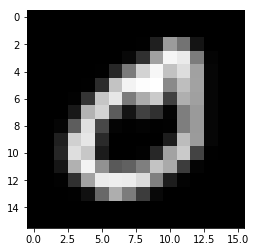

Display numpy-images : USPS 16x16 after normalisation to 0-1
(16, 16)
[[ 0.0000365   0.003178    0.0498455   0.1836895   0.27842751  0.272782
   0.262564    0.284412    0.25273049  0.208176    0.21567351  0.299867
   0.4222725   0.45699951  0.31546149  0.0886945 ]
 [ 0.000079    0.0068555   0.1089155   0.42177501  0.697604    0.74693501
   0.73790002  0.76167899  0.72753447  0.67713702  0.681669    0.74962598
   0.82360899  0.80387199  0.55534202  0.1601465 ]
 [ 0.000054    0.0047745   0.0812955   0.3908405   0.8158865   0.95978302
   0.96468198  0.96276599  0.92502999  0.87904352  0.86345249  0.85652751
   0.83722299  0.783871    0.55056202  0.164014  ]
 [ 0.0000365   0.003278    0.0598465   0.34029251  0.80466747  0.98330301
   0.98204052  0.922566    0.808608    0.67959899  0.60448402  0.53092653
   0.44464701  0.37166101  0.221719    0.059555  ]
 [ 0.0000655   0.005763    0.095676    0.4284105   0.84339702  0.98624599
   0.96179301  0.84984249  0.68738598  0.47737601  0.29939151  0

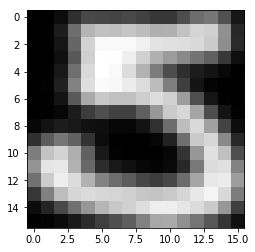

(7000, 256)
(930, 256)
(7000,)
(930,)


In [11]:
mnist_x_new_train, mnist_x_new_test, mnist_y_new_train, mnist_y_new_test,usps_x_new_train, usps_x_new_test, usps_y_new_train, usps_y_new_test=datasets()

#### Compiling and training VAE model

In [12]:
vae.compile(optimizer='adam', loss=vae_loss)

In [13]:
adda_train=np.concatenate((mnist_x_new_train[0:62768],usps_x_new_train),axis=0) #[0:8360] for class balancing
adda_test=np.concatenate((mnist_x_new_test,usps_x_new_test),axis=0)
from sklearn.utils import shuffle
adda_train= shuffle(adda_train, random_state=0)
adda_train= shuffle(adda_train, random_state=1)
adda_train= shuffle(adda_train, random_state=3)
print(np.shape(mnist_x_new_train))
print(np.shape(adda_train))

(63000, 256)
(71136, 256)


In [14]:
vae.fit(adda_train,adda_train, batch_size=24, epochs=80,shuffle=True)

Epoch 1/80
71136/71136 [==============================] - 14s - loss: 70.6480    
Epoch 2/80
71136/71136 [==============================] - 16s - loss: 67.0543    
Epoch 3/80
71136/71136 [==============================] - 18s - loss: 65.9766    
Epoch 4/80
71136/71136 [==============================] - 18s - loss: 65.2743    
Epoch 5/80
71136/71136 [==============================] - 19s - loss: 64.8318    
Epoch 6/80
71136/71136 [==============================] - 19s - loss: 64.4399    
Epoch 7/80
71136/71136 [==============================] - 20s - loss: 64.1464    
Epoch 8/80
71136/71136 [==============================] - 19s - loss: 63.9297    
Epoch 9/80
71136/71136 [==============================] - 20s - loss: 63.7535    
Epoch 10/80
71136/71136 [==============================] - 20s - loss: 63.6075    
Epoch 11/80
71136/71136 [==============================] - 20s - loss: 63.4699    
Epoch 12/80
71136/71136 [==============================] - 20s - loss: 63.3996    
Epoch 13/80
7

#### Visualisation of latent space using test data

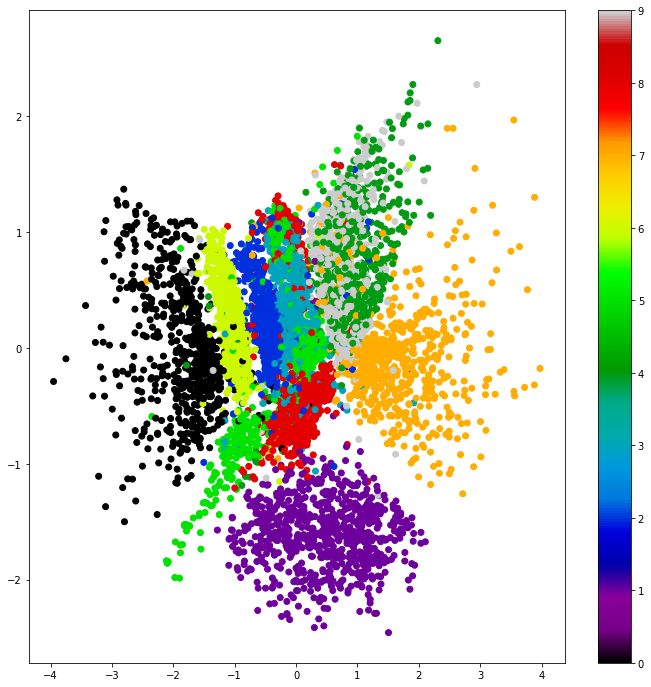

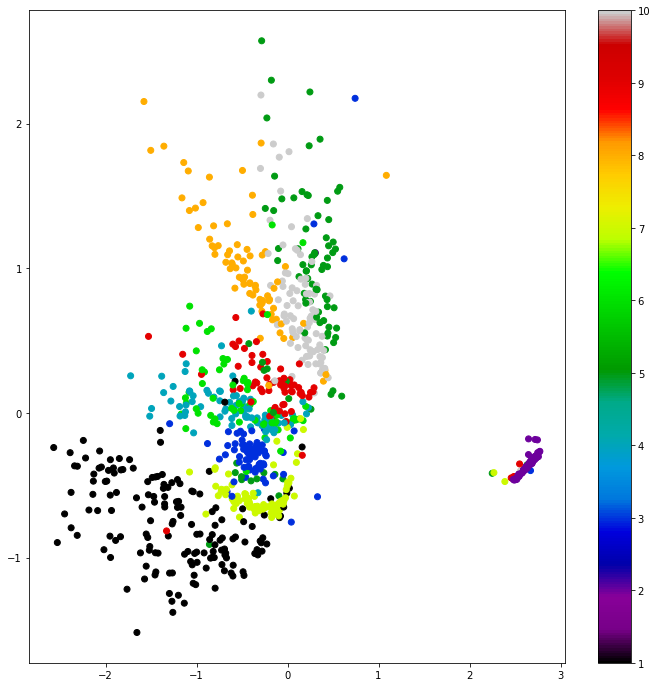

In [15]:
# 2D visualisation of features from images MNIST_test set in latent space 
latent_values_mnist=encoder.predict(mnist_x_new_test, batch_size=b_size)
latent_values_usps=encoder.predict(usps_x_new_test, batch_size=b_size)

vis_pca = PCA(n_components=2, random_state=0)
vis_data=vis_pca.fit_transform(latent_values_mnist)
plt.figure(figsize=(12, 12))
plt.scatter(vis_data[:, 0], vis_data[:, 1], c=mnist_y_new_test,cmap=plt.cm.nipy_spectral)
plt.colorbar()
plt.show()

# 2D visualisation of features from images USPS_test set in latent space 
vis_pca = PCA(n_components=2, random_state=0)
vis_data=vis_pca.fit_transform(latent_values_usps)
plt.figure(figsize=(12, 12))
plt.scatter(vis_data[:, 0], vis_data[:, 1], c=usps_y_new_test,cmap=plt.cm.nipy_spectral)
plt.colorbar()
plt.show()

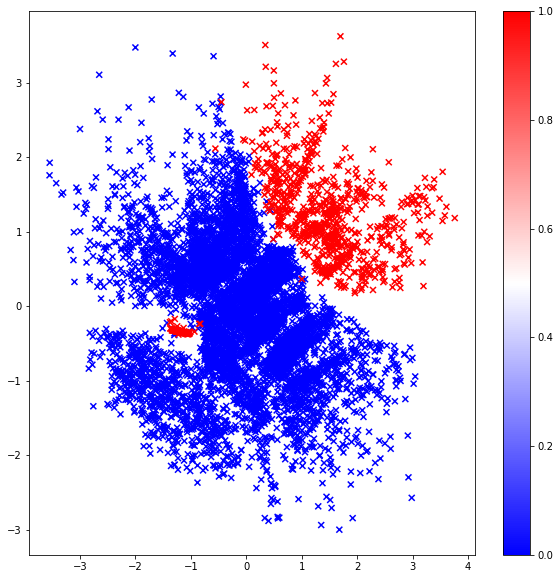

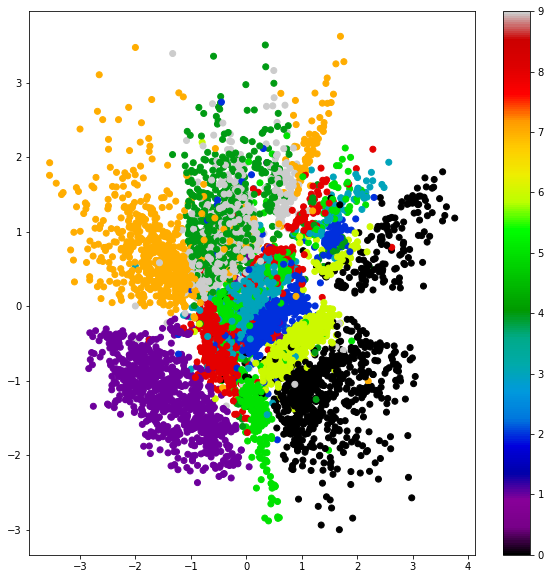

In [16]:
# 2D visualisation of features from images MNIST_test & USPS_test set in latent space 
# Red is USPS_test set & MNIST_test set
latent_values=np.concatenate((latent_values_mnist,latent_values_usps),axis=0)
labels_digits=np.concatenate((mnist_y_new_test,usps_y_new_test-1),axis=0)
labels_0=np.zeros(mnist_x_new_test.shape[0])
labels_1=np.ones(usps_x_new_test.shape[0])
labels=np.concatenate((labels_0,labels_1),axis=0)

vis_pca = PCA(n_components=2, random_state=0)
feature_vis=vis_pca.fit_transform(latent_values)

plt.figure(figsize=(10, 10))
plt.scatter(feature_vis[:, 0], feature_vis[:, 1], c=labels, marker='x', cmap=plt.cm.bwr, alpha=100)
plt.colorbar()
plt.show()

# 2D visualisation of features from images MNIST_test & USPS_test set in latent space 
plt.figure(figsize=(10, 10))
plt.scatter(feature_vis[:, 0], feature_vis[:, 1], c=labels_digits, marker='o', cmap=plt.cm.nipy_spectral, alpha=100)
plt.colorbar()
plt.show()

#### Saving the model

In [17]:
# storing model to a json file and weights in HDF5 format
model_json = encoder.to_json()
# saving model
with open("adv_exp_2_vae_encoder.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5 and saving it
encoder.save_weights("adv_exp_2_vae_encoder.h5")
print("Saved model to disk")


Saved model to disk


In [18]:
# storing model to a json file and weights in HDF5 format
model_json = decoder.to_json()
# saving model
with open("adv_exp_2_vae_decoder.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5 and saving it
decoder.save_weights("adv_exp_2_vae_decoder.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
# storing model to a json file and weights in HDF5 format
model_json = vae.to_json()
# saving model
with open("adv_exp_2_vae_vae.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5 and saving it
vae.save_weights("adv_exp_2_vae_vae.h5")
print("Saved model to disk")

Saved model to disk


#### Checking the recontruction ability of VAE model

In [20]:
def reconstructor():
    examples_to_show = 10
    encode_decode_ = vae.predict(usps_x_new_test[0:24])
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(usps_x_new_test[i], (16, 16)))
        a[1][i].imshow(np.reshape(encode_decode_[i], (16, 16)))
    f.show()
    plt.draw()
    plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


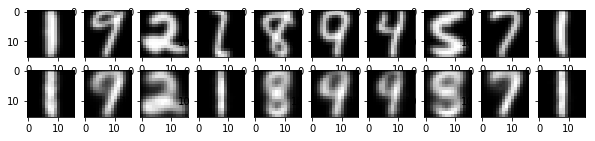

In [21]:
reconstructor()

#### Using VAE as a generative model

In [22]:
def generation():
    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 16
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder_generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

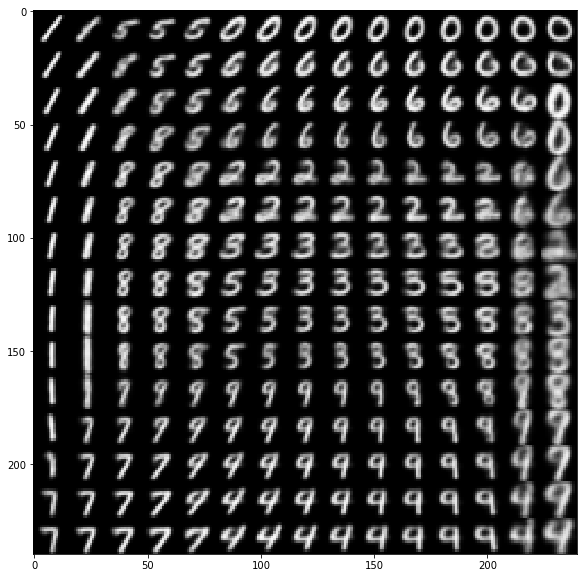

In [23]:
#Displaying images generated by the VAE autoencoder
generation()